In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from jax import random


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [3]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [5]:
# Number of unique patients
train['Patient'].nunique()

176

<AxesSubplot:ylabel='Frequency'>

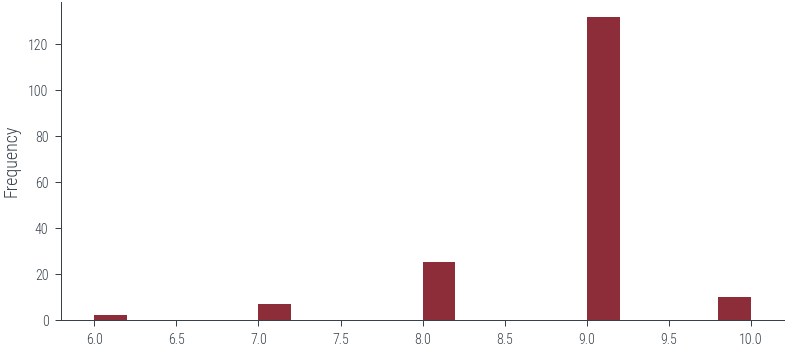

In [6]:
#Number of records per patient
train['Patient'].value_counts().plot(kind='hist', bins=20)

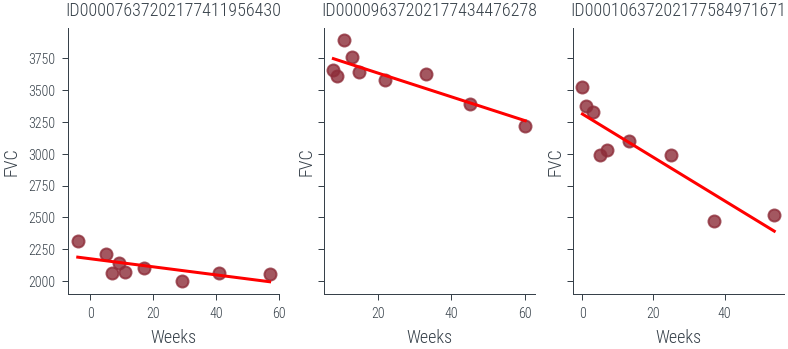

In [7]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, sharey=True)
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

In [8]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

In [9]:
import numpyro.distributions as dist

### Pooled model

$\alpha \sim \text{Normal}(0, 1)$

$\beta \sim \text{Normal}(0, 1)$

$\sigma \sim \text{HalfNormal}(100)$

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [10]:
# Convert NumPy arrays to numpy tensors
sample_weeks = train["Weeks"].values
fvc = train["FVC"].values

In [11]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(sample_weeks.reshape(-1, 1), fvc)

LinearRegression()

In [12]:
all_weeks = torch.arange(-12, 134, 1)

Text(0, 0.5, 'FVC')

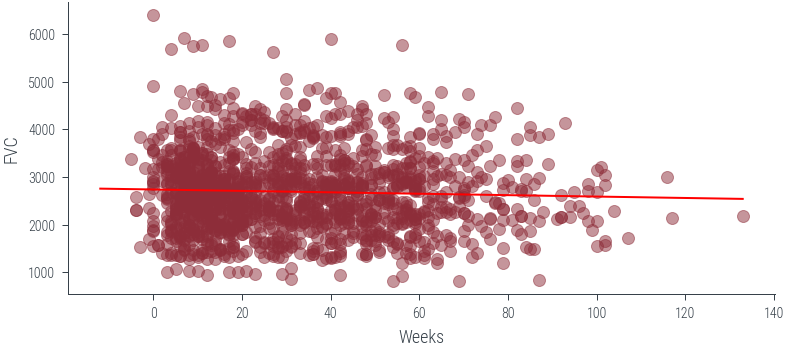

In [13]:
# Plot the data and the regression line
plt.scatter(sample_weeks, fvc, alpha=0.5)
plt.plot(all_weeks, lr.predict(all_weeks.reshape(-1, 1)), color="red")
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [14]:
lr.coef_, lr.intercept_

(array([-1.48471319]), 2737.784722381955)

In [15]:
def pooled_model(sample_weeks, fvc):
    a = numpyro.sample("a", dist.Normal(0., 500.))
    b = numpyro.sample("b", dist.Normal(0., 500.))
    sigma = numpyro.sample("sigma", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", dist.Normal(a + b * sample_weeks, sigma), obs=fvc)
    return fvc

In [16]:
sample_weeks.shape

(1549,)

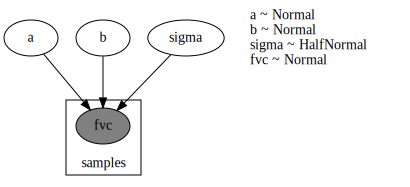

In [17]:
# Render the model graph
data = (train["Weeks"].values, train["FVC"].values)
numpyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "fvc": fvc}, 
                render_distributions=True,
                render_params=True,
                )

In [18]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

In [19]:
patient_code = train["patient_code"].values

In [20]:
from numpyro.infer import MCMC, NUTS, Predictive

In [21]:

nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)


CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8904, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [22]:
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

NameError: name 'Weeks' is not defined

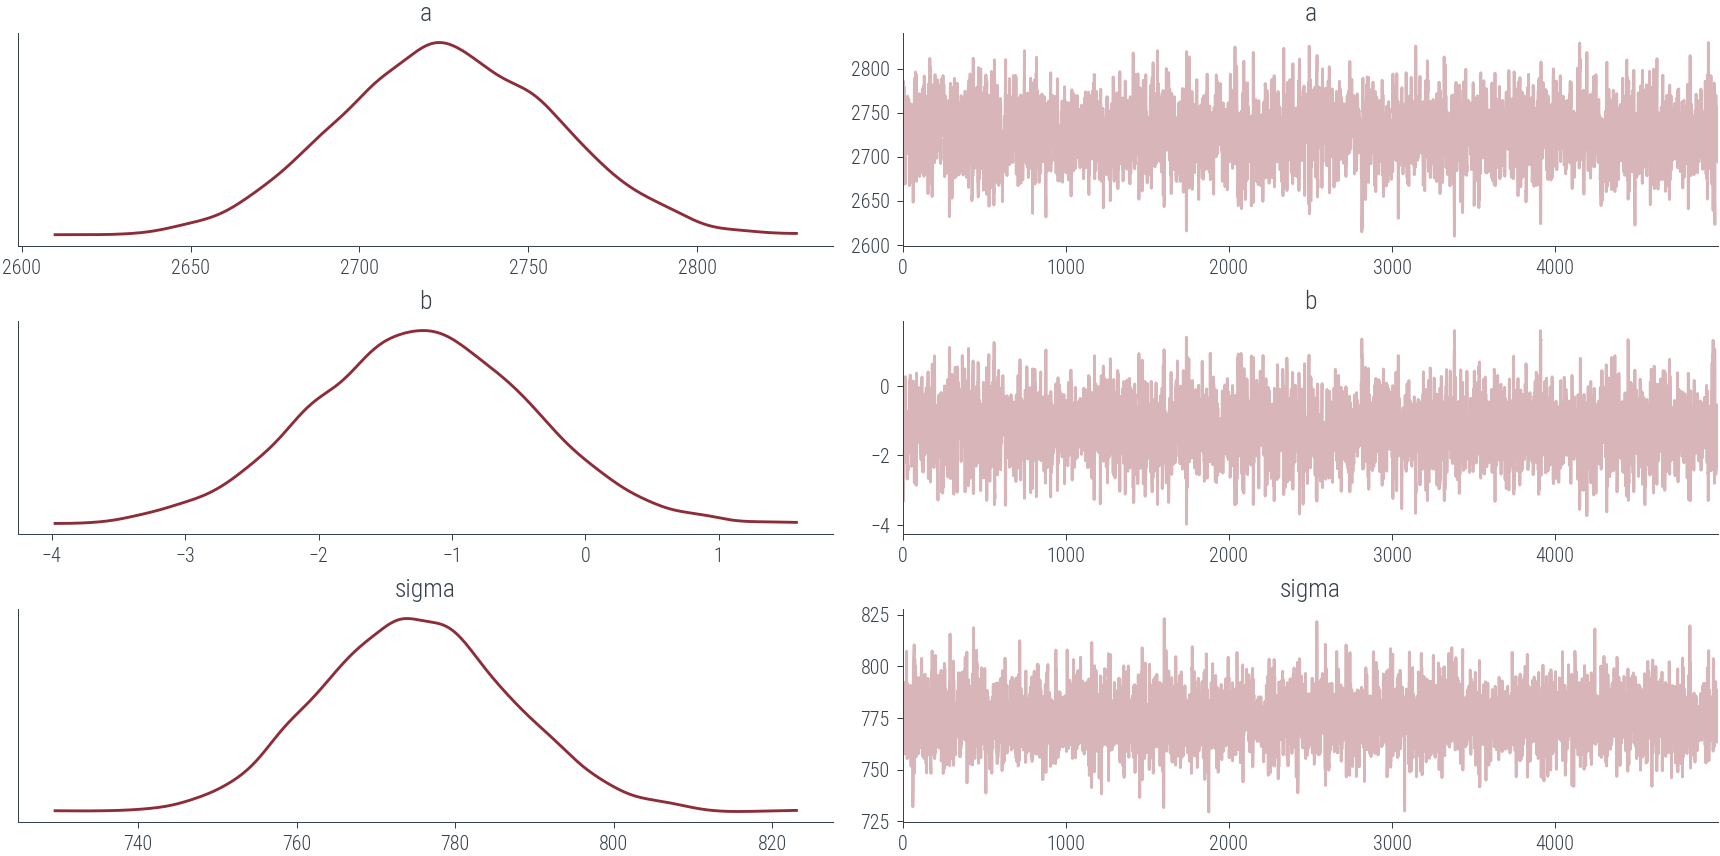

In [47]:
import arviz as az

data = az.from_pyro(mcmc)
az.plot_trace(data, compact=True);

In [48]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a   2725.69     32.50   2725.26   2671.43   2777.82   2183.48      1.00
         b     -1.24      0.82     -1.23     -2.56      0.14   2347.43      1.00
     sigma    774.97     12.29    774.72    755.31    794.92   3374.03      1.00

Number of divergences: 0


In [49]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())


In [50]:
predictive

Predictive()

In [51]:
# Predictive distribution
#predictive = Predictive(pooled_model, num_samples=2000)

In [52]:
predictions = predictive(all_weeks, None)

<AxesSubplot:>

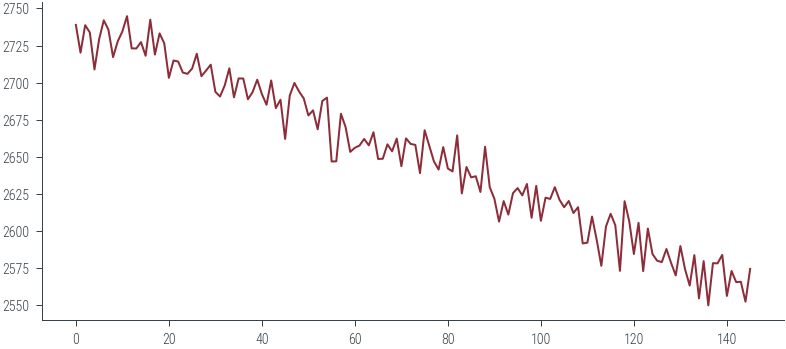

In [53]:
pd.DataFrame(predictions["fvc"]).mean().plot()

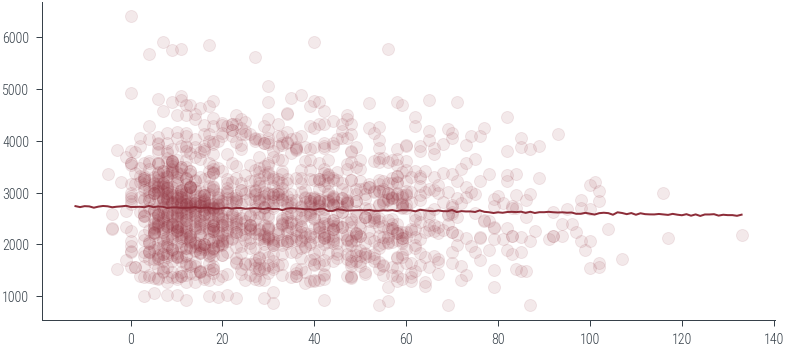

In [54]:
plt.plot(all_weeks, predictions["fvc"].mean(dim=0))
plt.scatter(sample_weeks, fvc, alpha=0.1)

Text(0, 0.5, 'FVC')

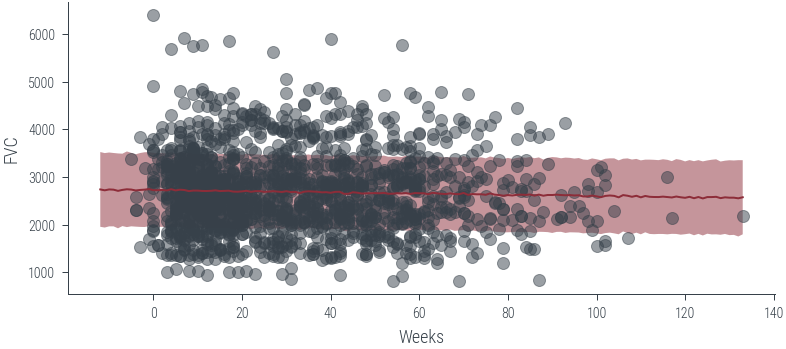

In [55]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(dim=0)
sigma = predictions["fvc"].std(dim=0)

# Plot the predictions
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.5)
plt.scatter(sample_weeks, fvc, alpha=0.5)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [56]:
# Unpooled model
def unpool_model(sample_weeks, patient_code, fvc=None):
    sigma = pyro.sample("sigma", pyro.distributions.HalfNormal(20.))
    with pyro.plate("patients", patient_code.max() + 1):
        a_p = pyro.sample("a_p", pyro.distributions.Normal(0, 500.))
        b_p = pyro.sample("b_p", pyro.distributions.Normal(0, 500.))
    with pyro.plate("samples", len(sample_weeks)):
        fvc = pyro.sample("fvc", pyro.distributions.Normal(a_p[patient_code] + b_p[patient_code] * sample_weeks, sigma), obs=fvc)
    return fvc

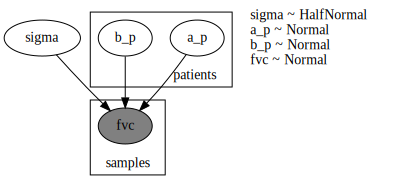

In [57]:
# Render the model graph
data = (torch.tensor(train["Weeks"].values), 
        torch.tensor(train["patient_code"].values), 
        torch.tensor(train["FVC"].values))
# torchify the data
pyro.render_model(unpool_model, model_args=data, 
                render_distributions=True,
                render_params=True,
                )

In [58]:
nuts_kernel_unpooled = NUTS(unpool_model)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=3000, warmup_steps=1000, num_chains=1)

In [59]:
mcmc_unpooled.run(*data)

Sample: 100%|██████████| 4000/4000 [10:30,  6.34it/s, step size=1.21e-01, acc. prob=0.824]


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


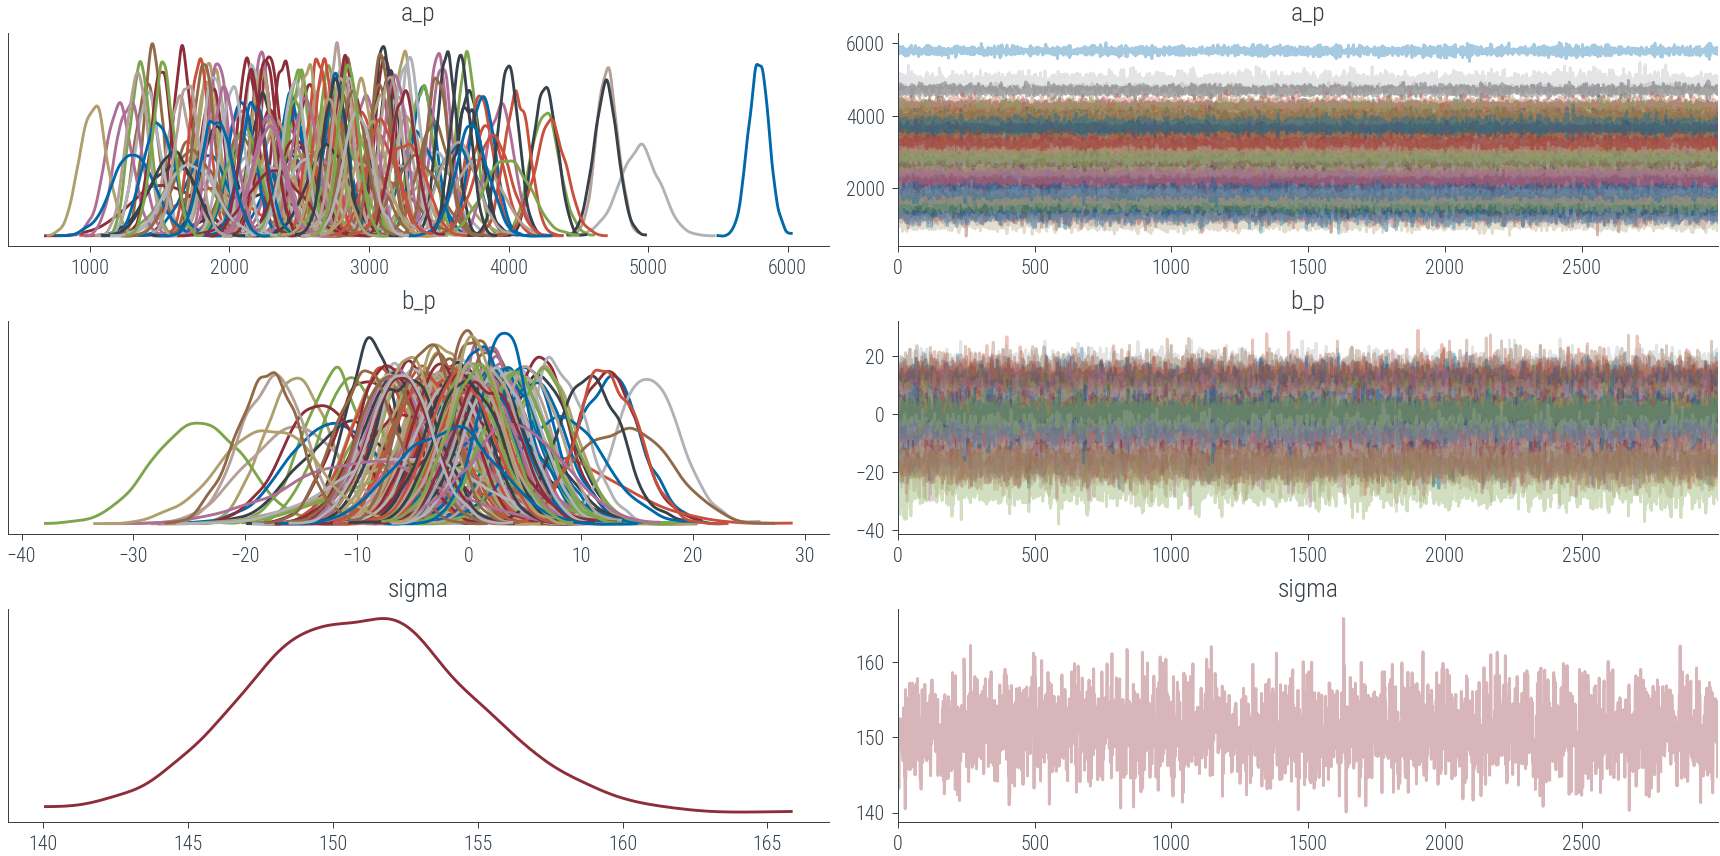

In [60]:
az.plot_trace(az.from_pyro(mcmc_unpooled), compact=True);

In [61]:
# Predictive distribution for unpooled model

predictive_unpooled = Predictive(unpool_model, mcmc_unpooled.get_samples())


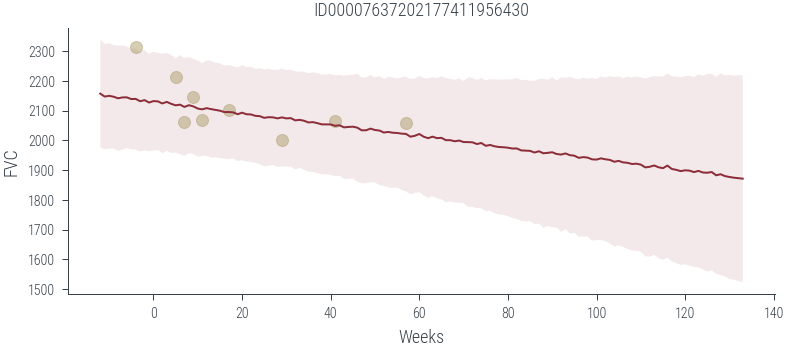

In [80]:
# Predictive distribution for unpooled model for all weeks for a given patient

all_weeks = torch.arange(-12, 134, 1)
def predict_unpooled(patient_code):
    predictions = predictive_unpooled(all_weeks, patient_code)
    mu = predictions["fvc"].mean(dim=0)
    sigma = predictions["fvc"].std(dim=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient(patient_code):
    mu, sigma = predict_unpooled(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    plt.scatter(sample_weeks[train["patient_code"] == patient_code], fvc[train["patient_code"] == patient_code], alpha=0.5)
    plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

plot_patient(torch.tensor(0))

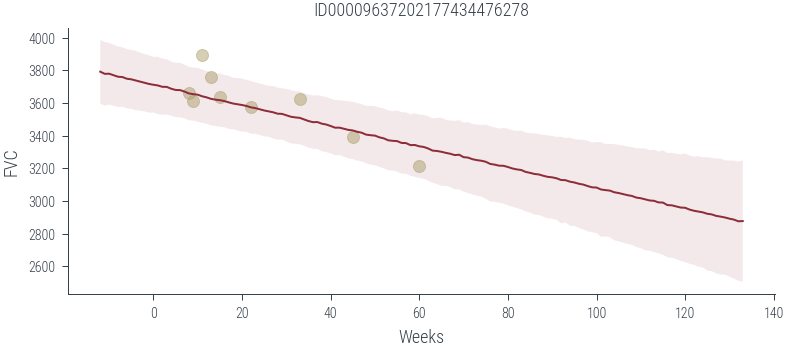

In [81]:
plot_patient(torch.tensor(1))

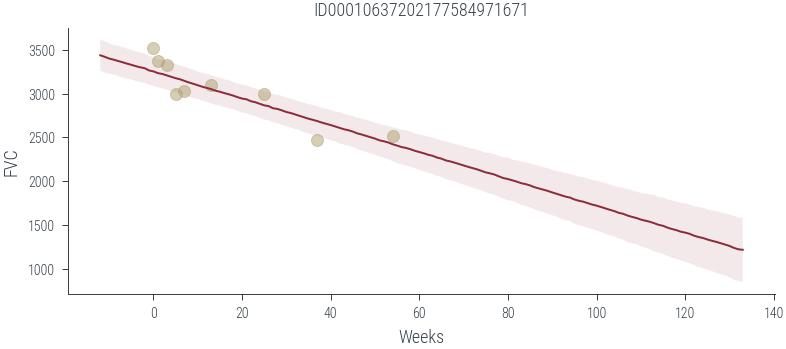

In [82]:
plot_patient(torch.tensor(2))

In [84]:
### Hierarchical model

def final_model(patient_code, Weeks, FVC_obs=None):
    μ_α = pyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = pyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = pyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = pyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with pyro.plate("plate_i", n_patients):
        α = pyro.sample("α", dist.Normal(μ_α, σ_α))
        β = pyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = pyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with pyro.plate("data", len(patient_code)):
        pyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)    

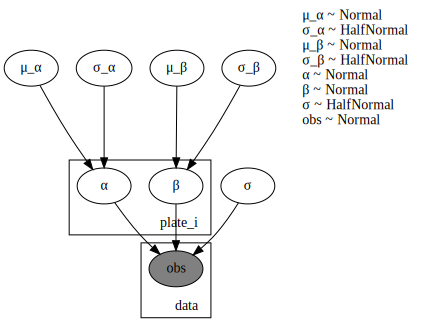

In [85]:
# Render the model graph
data = (torch.tensor(train["patient_code"].values), 
        torch.tensor(train["Weeks"].values), 
        torch.tensor(train["FVC"].values))

pyro.render_model(final_model, model_args=data,
                render_distributions=True,
                render_params=True,
                )


In [86]:
nuts_final = NUTS(final_model)

mcmc_final = MCMC(nuts_final, num_samples=1000, warmup_steps=500, num_chains=1)

mcmc_final.run(*data)


Sample:  90%|████████▉ | 1348/1500 [28:26,  1.44s/it, step size=3.37e-03, acc. prob=0.981]